# DeepGlobe Image Segmentation

[Reference](https://www.kaggle.com/code/nisaneretva/multiclass-segmentation-deepglobe-with-unet)

### Data
- The training data for Land Cover Challenge contains 803 satellite imagery in RGB, size 2448x2448.
- The imagery has 50cm pixel resolution, collected by DigitalGlobe's satellite.
- The dataset contains 171 validation and 172 test images (but no masks).
### Label
- Each satellite image is paired with a mask image for land cover annotation. The mask is a RGB image with 7 classes of labels, using color-coding (R, G, B) as follows.
    - Urban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)
    - Agriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.
    - Rangeland: 255,0,255 - Any non-forest, non-farm, green land, grass
    - Forest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.
    - Water: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.
    - Barren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation
    - Unknown: 0,0,0 - Clouds and others

File names for satellite images and the corresponding mask image are id _sat.jpg and id _mask.png. id is a randomized integer.

### Please note:
- The values of the mask image may not be pure 0 and 255. When converting to labels, please binarize them at threshold 128.

In [13]:
import numpy as np # linear algebra
import pandas as pd # 
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

In [14]:
TRAIN_DIR = "./deepglobe-land-cover-classification-dataset/train"
VALID_DIR = "./deepglobe-land-cover-classification-dataset/valid"
TEST_DIR = "./deepglobe-land-cover-classification-dataset/test"
COLOR_CODES = "./deepglobe-land-cover-classification-dataset/class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

# Data Augmentation
# albumentation

In [15]:
# Data cleaning
# List all files in the directory
def clean_files(directory):
    files = os.listdir(directory)

    # Iterate over the files
    for file in files:
        # Check if the file starts with "._"
        if file.startswith("._"):
            # Join the directory path and file name
            file_path = os.path.join(directory, file)
            # Delete the file
            os.remove(file_path)
            print(f"Deleted: {file_path}")

clean_files(TRAIN_DIR)
clean_files(VALID_DIR)
clean_files(TEST_DIR)

In [16]:
df = pd.read_csv(COLOR_CODES)
label_map = {}

for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
    
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [17]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg') and not filename.startswith("._")])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png') and not filename.startswith("._")])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [18]:
"""img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)
print(bla)
sample = [img, mask]

for i in range(len(sample)):
    plt.subplot(1, 2, i+1)
    plt.imshow(sample[i])
    plt.axis('off')
    
plt.show()"""

"img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)\nprint(bla)\nsample = [img, mask]\n\nfor i in range(len(sample)):\n    plt.subplot(1, 2, i+1)\n    plt.imshow(sample[i])\n    plt.axis('off')\n    \nplt.show()"

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)

        plus = conv + skip
        return plus

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256,512)
        self.bottleneck = ResidualBlock(512, 1024)        

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
        self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512) 
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        # encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1) 

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2) 
        
        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3) 

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)         

        x5 = self.bottleneck(x4) 

        x = self.dconv1(x5)        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)        
        x = torch.cat([x, conv3], dim=1)       
        x = self.dconv_up3(x)

        x = self.dconv3(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dconv_up2(x)

        x = self.dconv4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        seg = self.conv_last(x)

        return seg

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()

In [21]:
class Train():
    def __init__(self, model, dataloader, optimizer, num_epoch, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.device = device
        self.loss = loss
        self.loss_epochs = []
        self.iou_list = []
        self.num_epochs = num_epoch

    def calculate_iou(self, predictions, labels):
        # Assuming predictions and labels are tensors of shape (batch_size, num_classes, height, width)
        predictions = torch.argmax(predictions, dim=1)
        intersection = torch.sum(predictions & labels).float()
        union = torch.sum(predictions | labels).float()
        iou = (intersection + 1e-6) / (union + 1e-6)  # Adding epsilon to avoid division by zero
        return iou.item()

    def train(self):
        self.model.to(self.device)
        self.model.train()

        for epoch in range(self.num_epoch):
            total_loss = 0.0
            total_samples = 0

            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    labels = labels.squeeze().long()
                    loss = self.loss(predictions, labels)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)
                    dl.set_postfix({"Epoch": epoch + 1, "Loss": total_loss / total_samples})

            epoch_loss = total_loss / total_samples
            self.loss_epochs.append(epoch_loss)
            self.iou_list.append(self.calculate_iou(predictions, labels))
            
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}")



## Play here with the hyperparameters

In [22]:
num_classes = len(label_map.keys())

# Play with these hyperparameters for better results
lr = 0.001
batch_size = 4
num_epochs = 200

model = UNet(n_class=num_classes)
train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr)
loss = FocalLoss()

In [23]:
# Set device to cuda, mps or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else: 
    device = "mps"


In [24]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()
# Ignore AttributeError: 'Train' object has no attribute 'num_epochs' at the end


  0%|          | 0/201 [00:00<?, ?batch/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/var/folders/tx/n32g7pgx5dn47wpc89xx8v0w0000gn/T/ipykernel_89450/93752488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argumen

Epoch [1/200], Loss: 2.2114


  5%|▍         | 10/201 [01:53<36:16, 11.40s/batch, Epoch=2, Loss=2.25]


KeyboardInterrupt: 

[1.9622613317791284]


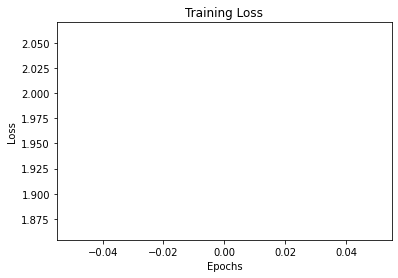

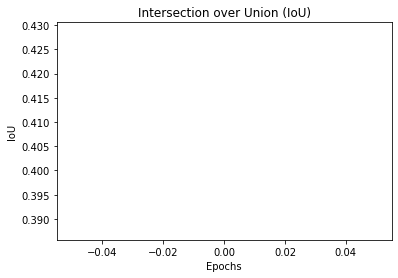

In [ ]:

losses = trainer.loss_epochs
ious = trainer.iou_list

print(losses)

# Plotting the loss values
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
# Plotting the IoU values
plt.plot(ious)
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Intersection over Union (IoU)')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'full_model.pth')
model.load_state_dict(torch.load('full_model.pth'))
model.to(device)
model.eval()

UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([2], device='mps:0')


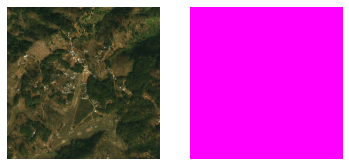

In [ ]:
img = cv2.imread("./deepglobe-land-cover-classification-dataset/test/83692_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()